In [1]:
# .py file auto-generated from the .ipynb file
import duckdb
import traceback
import logging

duckdb.execute("SET enable_progress_bar = true;")
duckdb.execute("SET progress_bar_time = 200;")
duckdb.execute("SET temp_directory = 'temp.tmp';")

# Set up a logger to show some timing info
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s %(message)s", datefmt="%H:%M:%S"
)


def is_in_notebook():
    # https://stackoverflow.com/a/67622408
    rstk = traceback.extract_stack(limit=1)[0]
    return rstk[0].startswith("<ipython")

In [2]:
if is_in_notebook():
    ! jupyter nbconvert --to script --no-prompt process_peaks.ipynb

[NbConvertApp] Converting notebook process_peaks.ipynb to script
[NbConvertApp] Writing 23735 bytes to process_peaks.py


In [3]:
# This notebook compiles itself to a python script.
# the meant usage is to run it with a subset of the data
# and then commit the file for use on cloud training.

if is_in_notebook():
    PATH_PREFIX = "../prospect_data"
    con = duckdb.connect("prospect_dev.ddb")
else:
    import logging
    from fsspec import filesystem

    # this line will throw an exception if the appropriate filesystem interface is not installed
    duckdb.register_filesystem(filesystem("gcs"))
    logging.info("Running in cloud environment!!!!")
    con = duckdb.connect("prospect_prod.ddb")
    PATH_PREFIX = "gs://jspp_prospect_mirror"
    PATH_PREFIX = "~/mount-folder"

METADATA_FILES = f"{PATH_PREFIX}/*meta_data.parquet"
ANNOTATION_FILES = f"{PATH_PREFIX}/*annotation.parquet"

In [4]:
if is_in_notebook():
    print(con.sql(f"SELECT * FROM parquet_scan('{METADATA_FILES}') LIMIT 5").to_df())

                                      raw_file  scan_number  \
0  01812a_GA3-TUM_third_pool_1_01_01-DDA-1h-R1        34341   
1  01812a_GA3-TUM_third_pool_1_01_01-DDA-1h-R1        39787   
2  01812a_GA3-TUM_third_pool_1_01_01-DDA-1h-R1        23850   
3  01812a_GA3-TUM_third_pool_1_01_01-DDA-1h-R1         5398   
4  01812a_GA3-TUM_third_pool_1_01_01-DDA-1h-R1        26459   

                                   modified_sequence  precursor_charge  \
0                                        DNYDQLVRIAK                 2   
1                                        MDLESQISDMR                 2   
2                                         QLQQIERQLK                 2   
3  PC[UNIMOD:4]C[UNIMOD:4]C[UNIMOD:4]QTTC[UNIMOD:...                 2   
4                                        LNTEVTTWRTK                 2   

   precursor_intensity         mz  precursor_mz fragmentation mass_analyzer  \
0          141925100.0  667.85678    667.854794           HCD          FTMS   
1           637602

In [5]:
if is_in_notebook():
    print("Couns of metadata files by fragmentation and mass analyzer")
    print(
        con.sql(
            "SELECT COUNT(*), internal.fragmentation, internal.mass_analyzer "
            f"FROM (SELECT * FROM parquet_scan('{METADATA_FILES}')) AS internal "
            "GROUP BY internal.fragmentation, internal.mass_analyzer"
        ).to_df()
    )

    print("\n\n\n\n")
    print("Counts of unique neutral losses")
    print(
        con.sql(
            "SELECT COUNT(*), internal.neutral_loss "
            f"FROM (SELECT * FROM parquet_scan('{ANNOTATION_FILES}')) AS internal "
            "GROUP BY internal.neutral_loss "
            "ORDER BY COUNT(*) DESC "
        ).to_df()
    )

Couns of metadata files by fragmentation and mass analyzer
   count_star() fragmentation mass_analyzer
0        237482           HCD          FTMS
1         59400           CID          ITMS
2         41852           HCD          ITMS





Counts of unique neutral losses
     count_star()   neutral_loss
0         8073708               
1         3692080            H2O
2         3111499            NH3
3         1777602        H2O-H2O
4         1761081        H2O-NH3
..            ...            ...
346         25457  C3H6SO-C3H6SO
347         25335   C3H6SO-CH4SO
348         17860    C8H7N-C8H7N
349         17192    C8H7N-C9H9N
350         16738    C9H9N-C9H9N

[351 rows x 2 columns]


In [6]:
if is_in_notebook():
    print(con.sql(f"SELECT * FROM parquet_scan('{ANNOTATION_FILES}') LIMIT 5").to_df())

  ion_type  no  charge  experimental_mass  theoretical_mass  intensity  \
0        y   3       1          302.22772        302.134661       0.02   
1        y   6       2          302.22772        302.140278       0.02   
2        b   3       1          302.22772        302.149919       0.02   
3        y   5       2          302.22772        302.686864       0.02   
4        y   3       1          320.32074        320.145226       0.05   

  neutral_loss  fragment_score    peptide_sequence  scan_number  \
0    C2H5N-H2O              65  AFTFDDEDDELSQLKESK        34380   
1  C4H11N-C4H8              39  AFTFDDEDDELSQLKESK        34380   
2          H2O              95  AFTFDDEDDELSQLKESK        34380   
3                           99  AFTFDDEDDELSQLKESK        34380   
4        C2H5N              70  AFTFDDEDDELSQLKESK        34380   

                                      raw_file  
0  01829a_GA3-TUM_third_pool_3_01_01-DDA-1h-R1  
1  01829a_GA3-TUM_third_pool_3_01_01-DDA-1h-R1  
2  01

In [7]:
logging.info("Defining types")
try:
    con.execute(
        """
        CREATE TYPE ion_type_type AS ENUM ('a', 'b', 'c', 'x', 'y', 'z');
        CREATE TYPE fragmentation_type AS ENUM ('HCD', 'CID', 'ETD');
        CREATE TYPE mass_analyzer_type AS ENUM ('ITMS', 'FTMS');
        """
    )
except duckdb.CatalogException:
    logging.info("Types already defined")
logging.info("Done defining types")

18:15:29 Defining types
18:15:29 Types already defined
18:15:29 Done defining types


In [8]:
logging.info("Creating annotation table")
query = f"""
CREATE OR REPLACE TABLE rt_qc AS
SELECT
    modified_sequence,
    MEDIAN(retention_time) as retention_time_m,
    MEDIAN(indexed_retention_time) as irt_m,
    QUANTILE_CONT(retention_time, 0.25) as retention_time_q25,
    QUANTILE_CONT(retention_time, 0.75) as retention_time_q75,
    QUANTILE_CONT(indexed_retention_time, 0.25) as irt_q25,
    QUANTILE_CONT(indexed_retention_time, 0.75) as irt_q75,
    COUNT(*) as n
FROM
(
    SELECT modified_sequence, andromeda_score, retention_time, indexed_retention_time,
    FROM
    (
        SELECT 
            modified_sequence,
            andromeda_score,
            retention_time,
            indexed_retention_time,
            row_number() OVER (
                PARTITION BY modified_sequence, fragmentation, mass_analyzer
                ORDER BY andromeda_score DESC
            ) AS scan_rank
        FROM "{METADATA_FILES}"
    ) FILER WHERE scan_rank <= 20            -- take top 20 scans
)
GROUP BY modified_sequence
HAVING n >= 5 AND irt_q75 - irt_q25 < 10    -- require at least 5 scans and irt range < 10
"""

con.sql(query)
logging.info("Created annotation table")

# Create indices
logging.info("Creating indices")
con.sql("CREATE INDEX modseq_idx ON rt_qc(modified_sequence)")
logging.info("Created indices")

glimpse = con.sql("SELECT * FROM rt_qc LIMIT 5")
if is_in_notebook():
    print(glimpse.to_df())

18:15:29 Creating annotation table
18:15:29 Created annotation table
18:15:29 Creating indices
18:15:29 Created indices


           modified_sequence  retention_time_m       irt_m  \
0                 AAEADGPLKR           19.4855   14.834332   
1          AARAVFLALSAQLLQAR           54.1565  102.648839   
2  AC[UNIMOD:4]IYPTTFYTSLPTK           44.6595   78.421547   
3               ADAIFSQERDPR           25.6570   30.302953   
4    ADGSYAAWLSRGSSTWLTAFVLK           59.4945  116.921813   

   retention_time_q25  retention_time_q75     irt_q25     irt_q75   n  
0            19.42400            19.57500   14.678899   15.060530  18  
1            54.15475            54.18125  102.625270  102.674947   8  
2            44.58275            44.95825   78.251935   78.808485  48  
3            25.60200            25.73400   30.156032   30.429818  45  
4            59.35400            59.56025  116.457815  117.400506  28  


In [9]:
logging.info("Creating filtered metadata table")
con.sql(
    f"""
    CREATE OR REPLACE TABLE filtered_meta AS
    SELECT
        raw_file,
        scan_number,
        modified_sequence,
        CAST (precursor_charge AS TINYINT) AS precursor_charge,
        precursor_intensity,
        mz,
        precursor_mz,
        CAST (fragmentation AS fragmentation_type) AS fragmentation,
        CAST (mass_analyzer AS mass_analyzer_type) AS mass_analyzer,
        retention_time,
        indexed_retention_time,
        orig_collision_energy,
        CAST (peptide_length AS TINYINT) AS peptide_length,
        aligned_collision_energy,
        retention_time_m,
        irt_m
    FROM (
        SELECT *,
        row_number() OVER (
                        PARTITION BY
                            "{METADATA_FILES}".modified_sequence,
                            "{METADATA_FILES}".precursor_charge,
                            "{METADATA_FILES}".fragmentation,
                            "{METADATA_FILES}".mass_analyzer,
                            "{METADATA_FILES}".orig_collision_energy
                        ORDER BY ABS("{METADATA_FILES}".retention_time - rt_qc.retention_time_m) ASC
                    ) AS rt_diff_rank
        FROM "{METADATA_FILES}" 
        JOIN rt_qc ON ("{METADATA_FILES}".modified_sequence = rt_qc.modified_sequence)
        WHERE retention_time <= retention_time_q75 AND retention_time >= retention_time_q25
    )
    WHERE rt_diff_rank <= 10 AND peptide_length < 35
    """
)
logging.info("Created filtered metadata table")

glimpse = con.sql("SELECT * FROM filtered_meta LIMIT 5")
count = con.sql("SELECT COUNT(*) FROM filtered_meta")

logging.info(f"Filtered metadata table has {count.to_df().iloc[0,0]} rows")
glimpse.to_df()

18:15:29 Creating filtered metadata table
18:15:29 Created filtered metadata table
18:15:29 Filtered metadata table has 131664 rows


,raw_file,scan_number,modified_sequence,precursor_charge,precursor_intensity,mz,precursor_mz,fragmentation,mass_analyzer,retention_time,indexed_retention_time,orig_collision_energy,peptide_length,aligned_collision_energy,retention_time_m,irt_m
0,01812a_GA3-TUM_third_pool_1_01_01-3xHCD-1h-R1,17003,AAAHGQWELQR,3,9704263.0,422.88278,422.882597,HCD,FTMS,24.130,26.572649,25.0,11,27.161428,24.140,26.301474
1,01812a_GA3-TUM_third_pool_1_01_01-3xHCD-1h-R1,16933,AAAHGQWELQR,3,24447170.0,422.88278,422.882697,HCD,FTMS,24.071,26.423535,25.0,11,27.161428,24.140,26.301474
2,01812a_GB3-TUM_third_pool_2_01_01-2xIT_2xHCD-1...,14720,AAAHGQWELQRVHAK,4,35617570.0,426.22876,426.228603,CID,ITMS,20.679,17.735715,35.0,15,35.000000,20.646,17.541545
3,01829a_BA3-TUM_third_pool_3_01_01-3xHCD-1h-R1,29402,AALLGRHC[UNIMOD:4]PLC[UNIMOD:4]VPAGEVFSQK,4,13239330.0,578.30160,578.301504,HCD,FTMS,37.908,62.056720,25.0,21,27.091641,37.890,61.975037
4,01829a_BA3-TUM_third_pool_3_01_01-3xHCD-1h-R1,29353,AALLGRHC[UNIMOD:4]PLC[UNIMOD:4]VPAGEVFSQK,4,24553030.0,578.30160,578.301604,HCD,FTMS,37.866,61.950180,25.0,21,27.091641,37.890,61.975037


In [10]:
# Create indices
logging.info("Creating indices")
con.sql(
    "DROP INDEX IF EXISTS modseq_fmeta_idx ; CREATE INDEX modseq_fmeta_idx ON filtered_meta(modified_sequence)"
)
logging.info("Created indices")

18:15:29 Creating indices
18:15:29 Created indices


In [11]:
if is_in_notebook():
    con.sql(
        f"""
            SELECT
                raw_file,
                scan_number,
                peptide_sequence,
                CAST (ion_type as ion_type_type) AS ion_type,
                CAST (no AS TINYINT) AS no,
                CAST (charge AS TINYINT) AS charge,
                intensity,
                experimental_mass,
                theoretical_mass,
                fragment_score,
            FROM "{ANNOTATION_FILES}"
            WHERE neutral_loss = '' AND scan_number = 44454 AND ion_type = 'y' AND no = 3 AND charge = 2 AND peptide_sequence LIKE 'SHYVAQTGILWLLM%'
            GROUP BY raw_file, scan_number, peptide_sequence, ion_type, no, charge, intensity, experimental_mass, theoretical_mass, fragment_score
        """
    ).to_df()

    # Note how multiple peaks can match a single fragment if there is ambiguity in the annotation
    # This seems to happen in very rare cases and it cannot be solved by the fragment score.

    # Just to get it over with I will use the max intensity one.

    # I am using here a cherry-picked example that popped up during my qc of the data
    # after the aggregation.

In [12]:
# out = con.sql(
#     f"""
#         EXPLAIN ANALYZE
#         CREATE OR REPLACE TABLE local_annotations AS
#         SELECT
#             filtered_meta.raw_file as raw_file,
#             filtered_meta.scan_number as scan_number,
#             peptide_sequence,
#             CAST (precursor_charge AS TINYINT) AS precursor_charge,
#             CAST (ion_type as ion_type_type) AS ion_type,
#             CAST (no AS TINYINT) AS no,
#             CAST (charge AS TINYINT) AS charge,
#             intensity,
#             -- mz, -- This is the observd mz
#             theoretical_mass as theoretical_fragment_mz,
#             precursor_mz, -- "same" as mz
#             CAST (fragmentation AS fragmentation_type) AS fragmentation,
#             CAST (mass_analyzer AS mass_analyzer_type) AS mass_analyzer,
#             retention_time,
#             indexed_retention_time,
#             orig_collision_energy,
#             aligned_collision_energy
#         FROM "{ANNOTATION_FILES}"
#         INNER JOIN filtered_meta
#         ON "{ANNOTATION_FILES}".peptide_sequence = filtered_meta.modified_sequence
#         AND "{ANNOTATION_FILES}".scan_number = filtered_meta.scan_number
#         AND "{ANNOTATION_FILES}".raw_file = filtered_meta.raw_file
#         WHERE neutral_loss = '' AND ion_type IN ('a', 'b', 'c', 'x', 'y', 'z')
#         -- ORDER BY peptide_sequence DESC;
#     """
# )

In [13]:
# NOTE!!! Here there isn un-handled ambiguity in the annotation. ...
# there can be multiple peaks that match a single ion type, no, charge, and sequence.

logging.info("Creating local annotation table")
out = con.sql(
    f"""
        EXPLAIN ANALYZE
        CREATE OR REPLACE TABLE local_annotations AS
        SELECT
            filtered_meta.raw_file as raw_file,
            filtered_meta.scan_number as scan_number,
            peptide_sequence,
            CAST (precursor_charge AS TINYINT) AS precursor_charge,
            CAST (ion_type as ion_type_type) AS ion_type,
            CAST (no AS TINYINT) AS no,
            CAST (charge AS TINYINT) AS charge,
            intensity,
            -- mz, -- This is the observd mz
            theoretical_mass as theoretical_fragment_mz,
            precursor_mz, -- "same" as mz
            CAST (fragmentation AS fragmentation_type) AS fragmentation,
            CAST (mass_analyzer AS mass_analyzer_type) AS mass_analyzer,
            retention_time,
            indexed_retention_time,
            orig_collision_energy,
            aligned_collision_energy
        FROM "{ANNOTATION_FILES}"
        INNER JOIN filtered_meta
        ON "{ANNOTATION_FILES}".peptide_sequence = filtered_meta.modified_sequence
        AND "{ANNOTATION_FILES}".scan_number = filtered_meta.scan_number
        AND "{ANNOTATION_FILES}".raw_file = filtered_meta.raw_file
        WHERE neutral_loss = '' AND fragment_score > 0.5 AND ion_type IN ('a', 'b', 'c', 'x', 'y', 'z')
        -- ORDER BY peptide_sequence DESC; -- 3 min with sorting, 11s without
    """
)
print(out["explain_value"].to_df().iloc[0, 0])

logging.info("Created local annotation table")
count = con.sql("SELECT COUNT(*) FROM local_annotations").fetchone()[0]
logging.info(f"Number of annotations: {count}")
glimpse = con.sql("SELECT * FROM local_annotations LIMIT 5").to_df()
if is_in_notebook():
    print(glimpse)

# Create indices ...
# logging.info("Creating indices")
# con.sql(
#     "CREATE INDEX idx_local_annotations_peptide_sequence ON local_annotations(peptide_sequence)"
# )
# logging.info("Created indices")

18:15:31 Creating local annotation table


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

18:15:34 Created local annotation table
18:15:34 Number of annotations: 3139994


┌─────────────────────────────────────┐
│┌───────────────────────────────────┐│
││    Query Profiling Information    ││
│└───────────────────────────────────┘│
└─────────────────────────────────────┘
         EXPLAIN ANALYZE         CREATE OR REPLACE TABLE local_annotations AS         SELECT             filtered_meta.raw_file as raw_file,             filtered_meta.scan_number as scan_number,             peptide_sequence,             CAST (precursor_charge AS TINYINT) AS precursor_charge,             CAST (ion_type as ion_type_type) AS ion_type,             CAST (no AS TINYINT) AS no,             CAST (charge AS TINYINT) AS charge,             intensity,             -- mz, -- This is the observd mz             theoretical_mass as theoretical_fragment_mz,             precursor_mz, -- "same" as mz             CAST (fragmentation AS fragmentation_type) AS fragmentation,             CAST (mass_analyzer AS mass_analyzer_type) AS mass_analyzer,             retention_time,             indexed_

In [14]:
# This ion has A LOT of annotated neutral losses, just making sure
# They have been filtered out (length should be 1)

scannr = "45741"
file_prefix = "01829a_BA3-TUM_third_pool_3_01_01-2xIT"
frag_no = 18
frag_ion_type = "y"
frag_charge = 2

query = f"""
SELECT
    *
FROM local_annotations
WHERE raw_file LIKE '{file_prefix}%'
AND scan_number = {scannr}
AND no = {frag_no}
AND ion_type = '{frag_ion_type}'
AND charge = {frag_charge}
ORDER BY peptide_sequence, no
"""

print(con.sql(query).to_df())

                                            raw_file  scan_number  \
0  01829a_BA3-TUM_third_pool_3_01_01-2xIT_2xHCD-1...        45741   

                              peptide_sequence  precursor_charge ion_type  no  \
0  M[UNIMOD:35]TDPNKMIINLALFGM[UNIMOD:35]TQSGK                 3        y  18   

   charge  intensity  theoretical_fragment_mz  precursor_mz fragmentation  \
0       2       0.04               990.026272    781.389403           CID   

  mass_analyzer  retention_time  indexed_retention_time  \
0          ITMS          50.266                93.62883   

   orig_collision_energy  aligned_collision_energy  
0                   35.0                      35.0  


In [15]:
out1 = con.sql(
    """
    EXPLAIN ANALYZE
    CREATE OR REPLACE TABLE middle_tmp AS
    SELECT 
        peptide_sequence,
        mass_analyzer,
        fragmentation,
        orig_collision_energy,
        COUNT(DISTINCT scan_number || '::' || raw_file) AS num_peptide_spec
    FROM (
        SELECT DISTINCT
            raw_file,
            scan_number,
            peptide_sequence,
            mass_analyzer,
            fragmentation,
            orig_collision_energy
        FROM
            local_annotations
    ) AS inner_tmp
    GROUP BY peptide_sequence, mass_analyzer, fragmentation, orig_collision_energy
    """
)

out2 = con.sql(
    """
    EXPLAIN ANALYZE
    CREATE OR REPLACE TABLE joint_local_annotations AS
    SELECT
        middle_tmp.peptide_sequence AS peptide_sequence, 
        middle_tmp.mass_analyzer AS mass_analyzer,
        middle_tmp.fragmentation AS fragmentation,
        middle_tmp.orig_collision_energy AS orig_collision_energy,
        num_peptide_spec,                             
        raw_file,                             
        scan_number,                             
        precursor_charge,                             
        ion_type,                             
        no,                             
        charge,                             
        intensity,                             
        theoretical_fragment_mz,                             
        precursor_mz,                             
        retention_time,                             
        indexed_retention_time,                             
        aligned_collision_energy,
    FROM middle_tmp
    INNER JOIN local_annotations
    ON middle_tmp.peptide_sequence = local_annotations.peptide_sequence
    AND middle_tmp.mass_analyzer = local_annotations.mass_analyzer
    AND middle_tmp.fragmentation = local_annotations.fragmentation
    AND middle_tmp.orig_collision_energy = local_annotations.orig_collision_energy
    """
)

print(out1["explain_value"].to_df().iloc[0, 0])
print(out2["explain_value"].to_df().iloc[0, 0])

count = con.sql("SELECT COUNT(*) FROM joint_local_annotations").fetchone()[0]
glimpse = con.sql("SELECT * FROM joint_local_annotations LIMIT 5").to_df()

logging.info(f"Number of annotations: {count}")
if is_in_notebook():
    print(glimpse)

18:15:35 Number of annotations: 3139994


┌─────────────────────────────────────┐
│┌───────────────────────────────────┐│
││    Query Profiling Information    ││
│└───────────────────────────────────┘│
└─────────────────────────────────────┘
     EXPLAIN ANALYZE     CREATE OR REPLACE TABLE middle_tmp AS     SELECT          peptide_sequence,         mass_analyzer,         fragmentation,         orig_collision_energy,         COUNT(DISTINCT scan_number || '::' || raw_file) AS num_peptide_spec     FROM (         SELECT DISTINCT             raw_file,             scan_number,             peptide_sequence,             mass_analyzer,             fragmentation,             orig_collision_energy         FROM             local_annotations     ) AS inner_tmp     GROUP BY peptide_sequence, mass_analyzer, fragmentation, orig_collision_energy     
┌─────────────────────────────────────┐
│┌───────────────────────────────────┐│
││        Total Time: 0.0623s        ││
│└───────────────────────────────────┘│
└───────────────────────────────────

In [16]:
logging.info("Dropping local annotations")
con.sql("DROP TABLE local_annotations")
logging.info("Dropped local annotations")

18:15:35 Dropping local annotations
18:15:35 Dropped local annotations


In [17]:
out3 = con.sql(
    """
    EXPLAIN ANALYZE
    CREATE OR REPLACE TABLE averaged_annotations AS
    SELECT
        LIST(raw_file),
        LIST(scan_number),
        peptide_sequence AS peptide_sequence,
        precursor_charge,
        ion_type AS fragment_ion_type,
        no AS fragment_no,
        charge AS fragment_charge,
        fragmentation,
        mass_analyzer,
        orig_collision_energy,
        theoretical_fragment_mz,
        num_peptide_spec,                                -- this is the number of spectra that were averaged
        SUM(intensity) AS total_intensity,
        SUM(intensity)/MAX(num_peptide_spec)
            AS fragment_intensity,
        MAX(intensity)
            AS max_fragment_intensity_prior_to_averaging,
        MEAN(precursor_mz)
            AS precursor_mz,
        MEAN(retention_time)
            AS retention_time,
        MEAN(indexed_retention_time)
            AS indexed_retention_time,
        MEAN(aligned_collision_energy)
            AS aligned_collision_energy,
        COUNT(*)
            AS num_averaged_peaks,
        COUNT(DISTINCT raw_file || '::' || scan_number)
            AS num_spectra,
        COUNT(DISTINCT raw_file || '::' || scan_number) / MAX(num_peptide_spec) 
            AS pct_averaged -- the percentage of spectra that contained this fragment
    FROM joint_local_annotations
    GROUP BY
        peptide_sequence,
        precursor_charge,
        fragment_ion_type,
        fragment_no,
        fragment_charge,
        fragmentation,
        mass_analyzer,
        orig_collision_energy,
        theoretical_fragment_mz,
        num_peptide_spec,                                -- this is the number of spectra that were averaged
    -- ORDER BY local_annotations.peptide_sequence, local_annotations.no
    """
)

print(out3["explain_value"].to_df().iloc[0, 0])

logging.info("Created averaged annotations table")

count = con.sql("SELECT COUNT(*) FROM averaged_annotations").fetchone()[0]
logging.info(f"Number of annotations: {count}")
glimpse = con.sql("SELECT * FROM averaged_annotations LIMIT 5").to_df()
if is_in_notebook():
    print(glimpse)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

18:15:38 Created averaged annotations table
18:15:38 Number of annotations: 871160


┌─────────────────────────────────────┐
│┌───────────────────────────────────┐│
││    Query Profiling Information    ││
│└───────────────────────────────────┘│
└─────────────────────────────────────┘
     EXPLAIN ANALYZE     CREATE OR REPLACE TABLE averaged_annotations AS     SELECT         LIST(raw_file),         LIST(scan_number),         peptide_sequence AS peptide_sequence,         precursor_charge,         ion_type AS fragment_ion_type,         no AS fragment_no,         charge AS fragment_charge,         fragmentation,         mass_analyzer,         orig_collision_energy,         theoretical_fragment_mz,         num_peptide_spec,                                -- this is the number of spectra that were averaged         SUM(intensity) AS total_intensity,         SUM(intensity)/MAX(num_peptide_spec)             AS fragment_intensity,         MAX(intensity)             AS max_fragment_intensity_prior_to_averaging,         MEAN(precursor_mz)             AS precursor_mz,         MEAN(

In [18]:
logging.info("Dropping joint_local_annotations")
con.execute("DROP TABLE joint_local_annotations")
logging.info("Dropped joint_local_annotations")

18:15:38 Dropping joint_local_annotations
18:15:38 Dropped joint_local_annotations


In [19]:
# logging.info("Creating averaged annotations table")
# con.sql(
#     """
#     CREATE OR REPLACE TABLE averaged_annotations AS
#     SELECT
#         LIST(raw_file),
#         LIST(scan_number),
#         local_annotations.peptide_sequence,
#         precursor_charge,
#         local_annotations.ion_type,
#         local_annotations.no
#             AS fragment_no,
#         local_annotations.charge
#             AS fragment_charge,
#         SUM(local_annotations.intensity)/MAX(num_peptide_spec)
#             AS fragment_intensity,
#         MAX(local_annotations.intensity)
#             AS max_fragment_intensity_prior_to_averaging,
#         local_annotations.theoretical_fragment_mz,
#         MEAN(local_annotations.precursor_mz)
#             AS precursor_mz,
#         local_annotations.fragmentation,
#         local_annotations.mass_analyzer,
#         MEAN(local_annotations.retention_time)
#             AS retention_time,
#         MEAN(indexed_retention_time)
#             AS indexed_retention_time,
#         local_annotations.orig_collision_energy,
#         MEAN(aligned_collision_energy)
#             AS aligned_collision_energy,
#         num_peptide_spec,                                -- this is the number of spectra that were averaged
#         COUNT(*)
#             AS num_averaged,
#         COUNT(*) / MAX(num_peptide_spec)
#             AS pct_averaged -- the percentage of spectra that contained this fragment
#     FROM (
#         SELECT
#             peptide_sequence,
#             mass_analyzer,
#             fragmentation,
#             orig_collision_energy,
#             COUNT(DISTINCT scan_number || '::' || raw_file) AS num_peptide_spec
#         FROM (
#             SELECT DISTINCT
#                 raw_file,
#                 scan_number,
#                 peptide_sequence,
#                 mass_analyzer,
#                 fragmentation,
#                 orig_collision_energy
#             FROM
#                 local_annotations
#         ) AS inner_tmp
#         GROUP BY peptide_sequence, mass_analyzer, fragmentation, orig_collision_energy
#     ) AS middle_tmp
#     JOIN local_annotations
#     ON middle_tmp.peptide_sequence = local_annotations.peptide_sequence
#     AND middle_tmp.mass_analyzer = local_annotations.mass_analyzer
#     AND middle_tmp.fragmentation = local_annotations.fragmentation
#     AND middle_tmp.orig_collision_energy = local_annotations.orig_collision_energy
#     GROUP BY ALL
#     ORDER BY local_annotations.peptide_sequence, local_annotations.no
#     """
# )
# logging.info("Created averaged annotations table")
#
# count = con.sql("SELECT COUNT(*) FROM averaged_annotations").fetchone()[0]
# logging.info(f"Number of annotations: {count}")
# glimpse = con.sql("SELECT * FROM averaged_annotations LIMIT 5").to_df()
# if is_in_notebook():
#     print(glimpse)
#
# # Create indices ...
# # logging.info("Creating indices")
# # con.sql(
# #     "CREATE INDEX idx_averaged_annotations_peptide_sequence ON averaged_annotations(peptide_sequence)"
# # )

In [20]:
if is_in_notebook():
    print(
        con.sql(
            "SELECT * from averaged_annotations " "ORDER BY pct_averaged DESC LIMIT 10"
        ).to_df()
    )

    print(
        con.sql(
            "SELECT * from averaged_annotations " "ORDER BY pct_averaged ASC LIMIT 10"
        ).to_df()
    )

                                      list(raw_file)  \
0  [01812a_GC3-TUM_third_pool_5_01_01-3xHCD-1h-R1...   
1  [01812a_GC3-TUM_third_pool_5_01_01-3xHCD-1h-R1...   
2  [01812a_GC3-TUM_third_pool_5_01_01-3xHCD-1h-R1...   
3  [01812a_GC3-TUM_third_pool_5_01_01-3xHCD-1h-R1...   
4  [01812a_GC3-TUM_third_pool_5_01_01-3xHCD-1h-R1...   
5  [01812a_GC3-TUM_third_pool_5_01_01-3xHCD-1h-R1...   
6  [01812a_GC3-TUM_third_pool_5_01_01-3xHCD-1h-R1...   
7  [01812a_GC3-TUM_third_pool_5_01_01-3xHCD-1h-R1...   
8  [01812a_GC3-TUM_third_pool_5_01_01-3xHCD-1h-R1...   
9  [01812a_GC3-TUM_third_pool_5_01_01-3xHCD-1h-R1...   

                                   list(scan_number)  \
0                       [37361, 37330, 37401, 37450]   
1                [21561, 21386, 21423, 21512, 21466]   
2  [38576, 38422, 38459, 38533, 38625, 38496, 386...   
3                                     [13887, 13930]   
4                                     [13887, 13930]   
5  [34261, 34022, 34203, 34102, 34065, 34420, 3

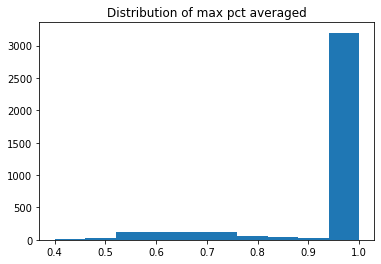

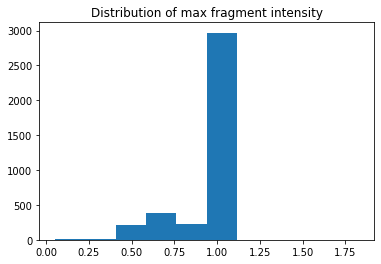

In [21]:
if is_in_notebook():
    from matplotlib import pyplot as plt

    df = con.sql(
        "SELECT peptide_sequence, MAX(pct_averaged) AS max_pct_avg, MAX(fragment_intensity) as max_intensity FROM averaged_annotations GROUP BY peptide_sequence"
    ).to_df()
    plt.hist(df["max_pct_avg"])
    plt.title("Distribution of max pct averaged")
    plt.show()

    plt.hist(df["max_intensity"])
    plt.title("Distribution of max fragment intensity")
    plt.show()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

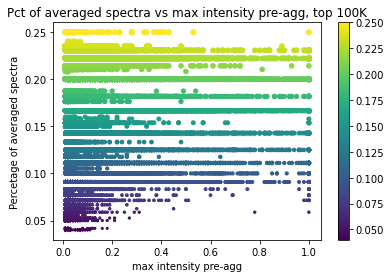

In [22]:
if is_in_notebook():
    from matplotlib import pyplot as plt

    df = con.sql(
        """
        SELECT * from averaged_annotations ORDER BY pct_averaged ASC LIMIT 100000
        """
    ).to_df()
    df
    plt.scatter(
        y=df["pct_averaged"],
        x=df["max_fragment_intensity_prior_to_averaging"],
        c=df["num_spectra"] / df["num_peptide_spec"],
        s=(df["num_spectra"] / df["num_peptide_spec"]) * 100,
    )
    plt.ylabel("Percetage of averaged spectra")
    plt.xlabel("max intensity pre-agg")
    plt.colorbar()
    plt.title("Pct of averaged spectra vs max intensity pre-agg, top 100K")
    # Save the plot to a file
    plt.savefig("peak_aggregation.png")
    plt.show()

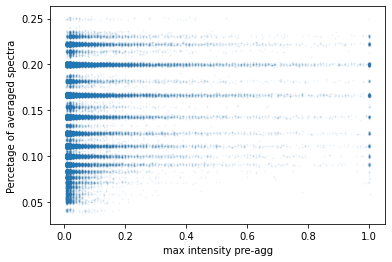

In [23]:
if is_in_notebook():
    import numpy as np

    plt.scatter(
        y=df["pct_averaged"] + np.random.normal(0, 0.001, len(df)),
        x=df["max_fragment_intensity_prior_to_averaging"]
        + np.random.normal(0, 0.001, len(df)),
        s=1,
        alpha=0.05,
    )
    plt.ylabel("Percetage of averaged spectra")
    plt.xlabel("max intensity pre-agg")

In [24]:
logging.info("Creating nested annotations table")
con.sql(
    """
    CREATE OR REPLACE TABLE nested_annotations AS
    SELECT
        peptide_sequence,
        -- TODO: Add stripped peptide here
        precursor_charge,
        LIST (fragment_ion_type),
        LIST (fragment_no), -- TODO consider filter for this 
        LIST (fragment_charge),
        LIST (fragment_intensity),
        LIST (theoretical_fragment_mz),
        fragmentation,
        mass_analyzer,
        MEAN(retention_time) as retention_time,
        MEAN(indexed_retention_time) as indexed_retention_time,
        orig_collision_energy,
        MEAN(aligned_collision_energy) as aligned_collision_energy,
    FROM averaged_annotations
    WHERE 
        -- pretty liberal filter, I am assuming that peaks that were not averaged 
        -- are low abundance ... BUT who knows ...
        pct_averaged > 0.1 
    GROUP BY peptide_sequence, precursor_charge, fragmentation, mass_analyzer, orig_collision_energy
    """
)
logging.info("Created nested annotations table")

18:15:44 Creating nested annotations table
18:15:44 Created nested annotations table


In [25]:
con.sql("SELECT * FROM nested_annotations LIMIT 5").to_df()

,peptide_sequence,precursor_charge,list(fragment_ion_type),list(fragment_no),list(fragment_charge),list(fragment_intensity),list(theoretical_fragment_mz),fragmentation,mass_analyzer,retention_time,indexed_retention_time,orig_collision_energy,aligned_collision_energy
0,QYVLTALAAR,2,"[y, y, y, b, y, y, b, b, y, y, y, y, y, y, y, ...","[4, 7, 8, 9, 2, 1, 4, 3, 9, 3, 6, 8, 4, 7, 3, ...","[2, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1, 2, 1, ...","[0.03699999999999999, 0.567, 0.531, 0.004, 0.1...","[215.642260302, 715.446101137, 814.514515137, ...",HCD,ITMS,40.112500,67.029740,28.0,30.57698
1,MYM[UNIMOD:35]TESFKIK,3,"[y, b, b, y, b, y, b, y, b, b, y, b, b, y, y, ...","[5, 7, 5, 4, 8, 6, 4, 2, 3, 6, 5, 6, 2, 8, 9, ...","[2, 3, 2, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 3, 3, ...","[0.1142857142857143, 0.02285714285714286, 0.00...","[311.699774802, 302.7839190003333, 336.6220192...",HCD,ITMS,29.643932,40.419247,28.0,30.57698
2,LVAIC[UNIMOD:4]HPLR,2,"[y, b, y, y, b, y, y, b, y, y, b, b, b, b, y, ...","[6, 2, 3, 7, 5, 4, 1, 8, 8, 2, 7, 7, 3, 4, 8, ...","[2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, ...","[0.026666666666666665, 0.035555555555555556, 0...","[398.218338802, 213.159754467, 385.255780137, ...",CID,ITMS,28.229152,36.822959,35.0,35.00000
3,GC[UNIMOD:4]GQYISYR,2,"[y, y, y, y, b, y, b, y, b, b, b, y, y, y, b, ...","[3, 2, 7, 5, 6, 5, 2, 8, 4, 3, 6, 6, 1, 2, 5, ...","[1, 2, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, ...","[0.43, 0.006666666666666667, 1.0, 0.61, 0.0066...","[425.214309137, 169.594778802, 886.44174413700...",HCD,ITMS,25.385078,29.593489,28.0,30.57698
4,GC[UNIMOD:4]GQYISYRC[UNIMOD:4]QEK,3,"[y, y, b, y, y, b, y, y]","[9, 8, 9, 12, 7, 2, 10, 11]","[2, 2, 2, 3, 2, 1, 2, 2]","[0.08333333333333333, 0.02666666666666667, 0.0...","[623.797878802, 542.266214302, 543.245282467, ...",CID,ITMS,21.364583,19.475244,35.0,35.00000


In [26]:
logging.info("Dropping averaged_annotations")
con.execute("DROP TABLE averaged_annotations")
logging.info("Dropped averaged_annotations")

18:15:44 Dropping averaged_annotations
18:15:44 Dropped averaged_annotations


In [27]:
"""
fragmentation	mass_analyzer	count_star()
0	HCD	FTMS	22066
1	CID	ITMS	4750
2	HCD	ITMS	4473
"""

counts = con.sql(
    "SELECT fragmentation, mass_analyzer, COUNT(*) FROM nested_annotations GROUP BY fragmentation, mass_analyzer"
).to_df()

logging.info("Counts per fragmentation and mass analyzer")
logging.info(counts)

18:15:44 Counts per fragmentation and mass analyzer
18:15:44   fragmentation mass_analyzer  count_star()
0           HCD          ITMS          4474
1           CID          ITMS          4751
2           HCD          FTMS         22068


In [28]:
# Export nested_annotations to parquet in bundles of ~20k
# Duckdb stores data in vectors of 2048 by default.
vectors_per_chunk = int(20_000 / 2048) + 1
index = 0

handle = con.execute("select * from nested_annotations")

while len(batch := handle.fetch_df_chunk(vectors_per_chunk)):
    batch.to_parquet(f"nested_annotations_{index}.parquet")
    if index == 0:
        print(batch.head(10))
    index += 1

                                    peptide_sequence  precursor_charge  \
0                                         QYVLTALAAR                 2   
1                              MYM[UNIMOD:35]TESFKIK                 3   
2                                LVAIC[UNIMOD:4]HPLR                 2   
3                                GC[UNIMOD:4]GQYISYR                 2   
4                  GC[UNIMOD:4]GQYISYRC[UNIMOD:4]QEK                 3   
5            TLQTATSLSKPQM[UNIMOD:35]IM[UNIMOD:35]YK                 3   
6                                       WQEMGYIFYPRK                 3   
7                                   ARSVHTWEPWSSSTAR                 3   
8  MGC[UNIMOD:4]C[UNIMOD:4]GC[UNIMOD:4]SGGC[UNIMO...                 2   
9                                   SGGTASSVDWIMEAAR                 2   

                             list(fragment_ion_type)  \
0  [y, y, y, b, y, y, b, b, y, y, y, y, y, y, y, ...   
1  [y, b, b, y, b, y, b, y, b, b, y, b, b, y, y, ...   
2  [y, b, y, y, b

In [29]:
con.sql("SHOW tables;")

┌────────────────────┐
│        name        │
│      varchar       │
├────────────────────┤
│ filtered_meta      │
│ middle_tmp         │
│ nested_annotations │
│ rt_qc              │
└────────────────────┘

In [30]:
# con.sql("PRAGMA storage_info('averaged_annotations');").to_df()["count"].sum() / 1e6
# # 50.8
# con.sql("PRAGMA storage_info('filtered_meta');").to_df()["count"].sum() / 1e6
# # 4.2
# con.sql("PRAGMA storage_info('joint_local_annotations');").to_df()["count"].sum() / 1e6
# # 106.75
# con.sql("PRAGMA storage_info('local_annotations');").to_df()["count"].sum() / 1e6
# # 100.4
# con.sql("PRAGMA storage_info('nested_annotations');").to_df()["count"].sum() / 1e6
# # 9.3
# con.sql("PRAGMA storage_info('rt_qc');").to_df()["count"].sum() / 1e6
# # 0.06
# con.sql("PRAGMA storage_info('middle_tmp');").to_df()["count"].sum() / 1e6
# # 0.24

In [31]:
# TODO add splitting
# TODO add split set
con.close()